In [1]:
import pennylane as qml
import pennylane.numpy as np
import matplotlib.pyplot as plt

# Constants


In [18]:
noise_probability = 0.8

Q_qubits = 1
A_qubits = 2
B_qubits = 2

Q_wires = list(range(Q_qubits))
A_wires = list(range(Q_qubits, Q_qubits + A_qubits))
B_wires = list(range(Q_qubits + A_qubits, Q_qubits + A_qubits + B_qubits))

#Dimensions of the unitary matrix for QA
dim = 2 ** (Q_qubits + A_qubits)

alpha_length = 18
beta_length = 38

#Quantum Device
dev = qml.device('default.mixed', wires=Q_qubits + A_qubits + B_qubits)

# Gradient Descent 
stepsize = 0.01
momentum = 0.9

# Number of iterations
num_its = 150

# Number of simulations
num_sim = 2

# Baseline Fidelity
f_0 = 0.822

# Circuit definition
![VQACircuit](./VQAcircuit.png)

![V W Definitions](./V%20W%20Definitions.png)

# $\hat{V}_{QA}$

In [19]:
def prepare_Q(U, wires):
    """Prepares Q into the quantum state defined by the unitary U

    Args:
        U (array[complex]): the matrix U to apply to the fiduciary quantum state of Q
        wires (array[int]): the wires representing Q. If Q is a single-qubit, then this should be an array of length 1.
    """
    qml.QubitUnitary(U, wires)

In [20]:
def prepare_V_QA(alpha, wires):
    """Prepares the V_QA parametric gate given the vector alpha for a Q with k=1 qubits

    Args:
        alpha (array[complex]): The alpha vector containing the angles used for rotation in the Pauli operators
        wires (array[int]): The wires to act on. wires[0] should represent Q, and wires[1..2] shoudl represent A
    """
    # First two gates for each wire
    qml.RY(alpha[0], wires=wires[0])
    qml.RX(alpha[1], wires=wires[0])

    qml.RY(alpha[6], wires=wires[1])
    qml.RX(alpha[7], wires=wires[1])

    qml.RY(alpha[12], wires=wires[2])
    qml.RX(alpha[13], wires=wires[2])

    # Controlled on wire 0
    qml.CRX(alpha[8], wires=[wires[0], wires[1]])
    qml.CRX(alpha[14], wires=[wires[0], wires[2]])

    # Controlled on wire 1
    qml.CRX(alpha[2], wires=[wires[1], wires[0]])
    qml.CRX(alpha[15], wires=[wires[1], wires[2]])

    # Controlled on wire 2
    qml.CRX(alpha[3], wires=[wires[2], wires[0]])
    qml.CRX(alpha[9], wires=[wires[2], wires[1]])

    # Last two gates for each wire
    qml.RY(alpha[4], wires=wires[0])
    qml.RX(alpha[5], wires=wires[0])

    qml.RY(alpha[10], wires=wires[1])
    qml.RX(alpha[11], wires=wires[1])

    qml.RY(alpha[16], wires=wires[2])
    qml.RX(alpha[17], wires=wires[2])

# $\hat{W}_{QAB}$

In [21]:
def prepare_W_QAB(beta, wires):
    """Prepares the W_QAB parametric gate given the vector beta for a Q with k=1 qubits

    Args:
        beta (array[complex]): The beta vector containing the angles used for rotation in the Pauli operators
        wires (array[int]): The wires to act on. wires[0] should represent Q, wires[1..2] should represent A, and wires[3..4] should represent B
    """
    # First two gates for each wire
    qml.RY(beta[0], wires=wires[0])
    qml.RX(beta[1], wires=wires[0])

    qml.RY(beta[10], wires=wires[1])
    qml.RX(beta[11], wires=wires[1])

    qml.RY(beta[20], wires=wires[2])
    qml.RX(beta[21], wires=wires[2])

    qml.RY(beta[30], wires=wires[3])
    qml.RX(beta[31], wires=wires[3])

    qml.RY(beta[34], wires=wires[4])
    qml.RX(beta[35], wires=wires[4])

    # Controlled on wire 3
    qml.CRX(beta[2], wires=[wires[3], wires[0]])
    qml.CRZ(beta[3], wires=[wires[3], wires[0]])

    qml.CRX(beta[12], wires=[wires[3], wires[1]])
    qml.CRZ(beta[13], wires=[wires[3], wires[1]])

    qml.CRX(beta[22], wires=[wires[3], wires[2]])
    qml.CRZ(beta[23], wires=[wires[3], wires[2]])

    # Controlled on wire 4
    qml.CRX(beta[4], wires=[wires[4], wires[0]])
    qml.CRZ(beta[5], wires=[wires[4], wires[0]])

    qml.CRX(beta[14], wires=[wires[4], wires[1]])
    qml.CRZ(beta[15], wires=[wires[4], wires[1]])

    qml.CRX(beta[24], wires=[wires[4], wires[2]])
    qml.CRZ(beta[25], wires=[wires[4], wires[2]])

    # Middle rotation gates for each wire
    qml.RY(beta[6], wires=wires[0])
    qml.RX(beta[7], wires=wires[0])

    qml.RY(beta[16], wires=wires[1])
    qml.RX(beta[17], wires=wires[1])

    qml.RY(beta[26], wires=wires[2])
    qml.RX(beta[27], wires=wires[2])

    qml.RY(beta[22], wires=wires[3])
    qml.RX(beta[23], wires=wires[3])

    qml.RY(beta[36], wires=wires[4])
    qml.RX(beta[37], wires=wires[4])

    # Controlled to apply on wire 0
    qml.ctrl(qml.RZ(beta[8], wires=wires[0]), control=[wires[3], wires[4]], control_values=[1, 0])
    qml.ctrl(qml.RX(beta[9], wires=wires[0]), control=[wires[3], wires[4]], control_values=[1, 0])

    # Controlled to apply on wire 1
    qml.ctrl(qml.RZ(beta[18], wires=wires[1]), control=[wires[3], wires[4]], control_values=[1, 1])
    qml.ctrl(qml.RX(beta[19], wires=wires[1]), control=[wires[3], wires[4]], control_values=[1, 1])

    # Controlled to apply on wire 2
    qml.ctrl(qml.RZ(beta[28], wires=wires[2]), control=[wires[3], wires[4]], control_values=[0, 1])
    qml.ctrl(qml.RX(beta[29], wires=wires[2]), control=[wires[3], wires[4]], control_values=[0, 1])

# Calculate Hamiltonians for Fidelity and Wasserstein

# Fidelity Hamiltonian
![Hfid](./Hfid.png)

# Fidelity Cost Function
![C_fid](./C_fid.png)

# Wasserstein Fidelity and Cost
![HandC_wass](./HandC_wass.png)

In [22]:
# Get the fidelity hamiltonian matrix from the 0 state
@qml.qnode(dev)
def fiduciary_density(wires):
    return qml.density_matrix(wires)

#Calculate the hamiltonian for the fiduciary cost
H_QA_fid = np.identity(dim) - fiduciary_density(Q_wires + A_wires)

def wass_hamiltonian():
    H_wass = np.zeros((dim, dim))
    for i in range (1, dim):
        vec = np.zeros((dim, 1))
        vec[i, 0] = 1
        
        # Binary 011, 101, 110
        if i == 3 or i == 5 or i == 6:
            density_mat = 2 * np.outer(vec, vec.T)
        # Binary 111
        elif i == 7:
            density_mat = 3 * np.outer(vec, vec.T)
        # Binary 001, 010, 100
        else:
            density_mat = np.outer(vec, vec.T)
            
        H_wass += density_mat
    return H_wass

H_QA_wass = wass_hamiltonian()

# Define Kraus Operators for Noise

In [23]:
phase_K0 = np.sqrt(1 - noise_probability) * np.kron(np.kron(qml.Identity.compute_matrix(), qml.Identity.compute_matrix()), qml.Identity.compute_matrix())
phase_K1 = np.sqrt(noise_probability / 3) * np.kron(np.kron(qml.PauliZ.compute_matrix(), qml.Identity.compute_matrix()), qml.Identity.compute_matrix())
phase_K2 = np.sqrt(noise_probability / 3) * np.kron(np.kron(qml.Identity.compute_matrix(), qml.PauliZ.compute_matrix()), qml.Identity.compute_matrix())
phase_K3 = np.sqrt(noise_probability / 3) * np.kron(np.kron(qml.Identity.compute_matrix(), qml.Identity.compute_matrix()), qml.PauliZ.compute_matrix())

phaseflip_kraus_ops = [phase_K0, phase_K1, phase_K2, phase_K3]

bit_K0 = np.sqrt(1 - noise_probability) * np.kron(np.kron(qml.Identity.compute_matrix(), qml.Identity.compute_matrix()), qml.Identity.compute_matrix())
bit_K1 = np.sqrt(noise_probability / 3) * np.kron(np.kron(qml.PauliX.compute_matrix(), qml.Identity.compute_matrix()), qml.Identity.compute_matrix())
bit_K2 = np.sqrt(noise_probability / 3) * np.kron(np.kron(qml.Identity.compute_matrix(), qml.PauliX.compute_matrix()), qml.Identity.compute_matrix())
bit_K3 = np.sqrt(noise_probability / 3) * np.kron(np.kron(qml.Identity.compute_matrix(), qml.Identity.compute_matrix()), qml.PauliX.compute_matrix())

bitflip_kraus_ops = [bit_K0, bit_K1, bit_K2, bit_K3]


# Implementation of the VQA returning the final density matrix for fidelity calculations

In [24]:
@qml.qnode(dev)
def find_density(U, alpha, beta, bitFlip=True):
    prepare_Q(U, Q_wires)
    prepare_V_QA(alpha, Q_wires + A_wires)

    # Insert noise according to boolean value
    if (bitFlip):
        qml.QubitChannel(bitflip_kraus_ops, wires=[0,1,2])
    else: 
        qml.QubitChannel(phaseflip_kraus_ops, wires=[0,1,2])
    
    prepare_W_QAB(beta, Q_wires + A_wires + B_wires)
    qml.adjoint(prepare_V_QA)(alpha, Q_wires + A_wires)
    qml.adjoint(prepare_Q)(U, Q_wires)
    return qml.density_matrix(wires=[0,1,2])

# Implementation of the VQA returning the density matrix after unitary

In [25]:
@qml.qnode(dev)
def unitary_density():
    return qml.density_matrix(wires=[0,1,2])

# Implementation of the VQA returning the cost

In [26]:
@qml.qnode(dev)
def VQA_fidelity(U, alpha=None, beta=None, bitFlip=True):
    prepare_Q(U, Q_wires)
    prepare_V_QA(alpha, Q_wires + A_wires)

    # Insert noise according to boolean value
    if (bitFlip):
        qml.QubitChannel(bitflip_kraus_ops, wires=[0,1,2])
    else: 
        qml.QubitChannel(phaseflip_kraus_ops, wires=[0,1,2])
    
    prepare_W_QAB(beta, Q_wires + A_wires + B_wires)
    qml.adjoint(prepare_V_QA)(alpha, Q_wires + A_wires)
    qml.adjoint(prepare_Q)(U, Q_wires)
    return qml.expval(qml.Hermitian(H_QA_fid, wires=[0,1,2]))
    

@qml.qnode(dev)
def VQA_wasserstein(U, alpha=None, beta=None, bitFlip=True):
    prepare_Q(U, Q_wires)
    prepare_V_QA(alpha, Q_wires + A_wires)

    # Insert noise according to boolean value
    if (bitFlip):
        qml.QubitChannel(bitflip_kraus_ops, wires=[0,1,2])
    else: 
        qml.QubitChannel(phaseflip_kraus_ops, wires=[0,1,2])

    prepare_W_QAB(beta, Q_wires + A_wires + B_wires)
    qml.adjoint(prepare_V_QA)(alpha, Q_wires + A_wires)
    qml.adjoint(prepare_Q)(U, Q_wires)
    
    return qml.expval(qml.Hermitian(H_QA_wass, wires=[0,1,2]))

# Cost Function (Fidelity)

In [27]:
def fidelity_cost_bitflip_noise(U):
    def compute_cost(alpha, beta):
        return VQA_fidelity(U, alpha, beta, True)

    return compute_cost

In [28]:
def fidelity_cost_phaseflip_noise(U):
    def compute_cost(alpha, beta):
        return VQA_fidelity(U, alpha, beta, False)

    return compute_cost

In [29]:
def wasserstein_cost_bitflip_noise(U):
    def compute_cost(alpha, beta):
        return VQA_wasserstein(U, alpha, beta, True)
    
    return compute_cost

In [30]:
def wasserstein_cost_phaseflip_noise(U):
    def compute_cost(alpha, beta):
        return VQA_wasserstein(U, alpha, beta, False)
    
    return compute_cost

# Reproducing Results

In [35]:
def simulation(noiseModel, bitFlip):
    opt = qml.MomentumOptimizer(stepsize, momentum)

    # Create unitary set of 6 matrices
    I = qml.Identity.compute_matrix()
    X = qml.PauliX.compute_matrix()
    H = qml.Hadamard.compute_matrix()
    S = qml.S.compute_matrix()
    unitaries = [I, X, H, H @ X, S @ H, S @ H @ X]
    
    density_matrices = []
    totalIterations = 0
    for unitary in unitaries:
        alpha = np.random.uniform(0, np.pi, size=(alpha_length,))
        beta = np.random.uniform(0, np.pi, size=(beta_length,))
        i = 0
        running_costs = []
        while i < num_its:
            (alpha, beta), _cost = opt.step_and_cost(noiseModel(unitary), alpha, beta)
            
            running_costs.append(_cost)
            i += 1
            
            if len(running_costs) > 2 and abs(_cost - running_costs[-2]) < 1e-3:
                print("CONVERGING!")
                break

                


        density_matrices.append(find_density(unitary, alpha, beta, bitFlip))
        totalIterations += i

    #Find ideal state for fidelity
    ideal_state = unitary_density()

    #Find state after error correction
    final_state = np.zeros((dim, dim), dtype=complex)
    for i in range(len(density_matrices)):
        final_state += density_matrices[i]
    
    final_state /= len(unitaries)

    fidelity = qml.math.fidelity(ideal_state, final_state)    
    return alpha, beta, totalIterations, fidelity


In [36]:
def plotSimulation(wassIterations, fidelityIterations, wassFidelity, fidelityFidelity, noiseType, pltIterations=False):
   if pltIterations:
      plt.hist(wassIterations, color='blue', label='Wasserstein', alpha=0.5)
      plt.hist(fidelityIterations, color='orange', label='Fidelity', alpha=0.5)

      plt.xlabel("Number of iterations")
      plt.ylabel("Number of simulations")
      plt.legend(loc='upper right')
      plt.title("# Simulations vs # Iterations for "+ noiseType + "Noise")
      plt.show()

   plt.hist(wassFidelity, color='blue', label='Wasserstein', alpha=0.5, rwidth=1, align='left')
   plt.hist(fidelityFidelity, color='orange', label='Fidelity', alpha=0.5, rwidth=1, align='left')
   plt.hist([f_0], color='green', label='F0', alpha=1, rwidth=.25, align='left')
   plt.xlim(0.0,1.0)
   plt.xlabel("Average Fidelity")
   plt.ylabel("Number of simulations")
   plt.legend(loc='upper right')
   plt.title("# Simulations vs Average Fidelity for " + noiseType + " Noise")
   plt.show()

## Bitflip results

In [37]:
FidelityIterationsBitflip = []
fidelityFidelityBitflip = []

for i in range(num_sim):
    _, _, iterations, fidelity = simulation(fidelity_cost_bitflip_noise, True)

    FidelityIterationsBitflip.append(iterations)
    fidelityFidelityBitflip.append(fidelity)


KeyboardInterrupt: 

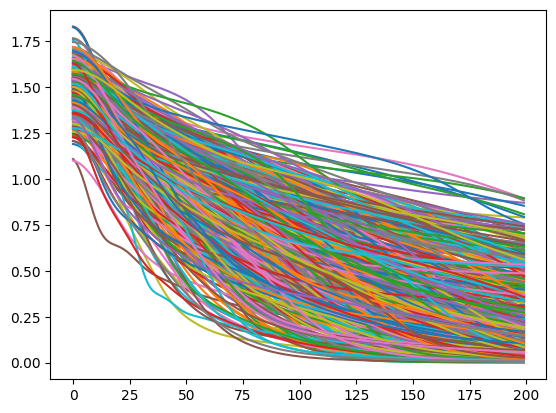

In [18]:
wassIterationsBitflip = []
wassFidelityBitflip = []

for i in range(num_sim):
    _, _, iterations, fidelity = simulation(wasserstein_cost_bitflip_noise, True)

    wassIterationsBitflip.append(iterations)
    wassFidelityBitflip.append(fidelity)


In [19]:
print(FidelityIterationsBitflip)
print(fidelityFidelityBitflip)

print(wassIterationsBitflip)
print(wassFidelityBitflip)

[200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200,

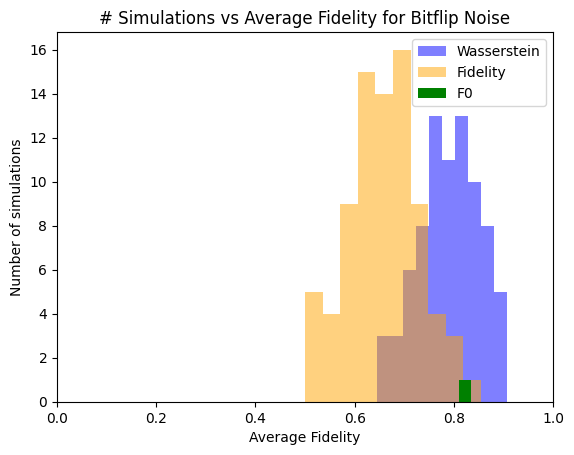

In [20]:
plotSimulation(wassIterationsBitflip, FidelityIterationsBitflip, wassFidelityBitflip, fidelityFidelityBitflip, "Bitflip")

## Phaseflip Results

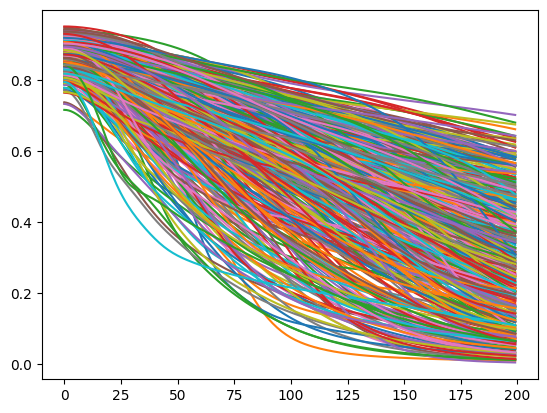

In [21]:
fidelityIterationsPhaseFlip = []
fidelityFidelityPhaseFlip = []

for i in range(num_sim):
    _, _, iterations, fidelity = simulation(fidelity_cost_phaseflip_noise, False)

    fidelityIterationsPhaseFlip.append(iterations)
    fidelityFidelityPhaseFlip.append(fidelity)


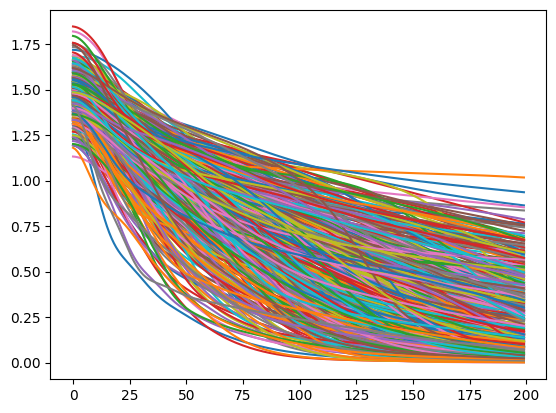

In [22]:
wassIterationsPhaseflip = []
wassFidelityPhaseflip = []

for i in range(num_sim):
    _, _, iterations, fidelity = simulation(wasserstein_cost_phaseflip_noise, False)

    wassIterationsPhaseflip.append(iterations)
    wassFidelityPhaseflip.append(fidelity)


In [23]:
print(wassIterationsPhaseflip)
print(wassFidelityPhaseflip)

print(fidelityIterationsPhaseFlip)
print(fidelityFidelityPhaseFlip)

[200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200,

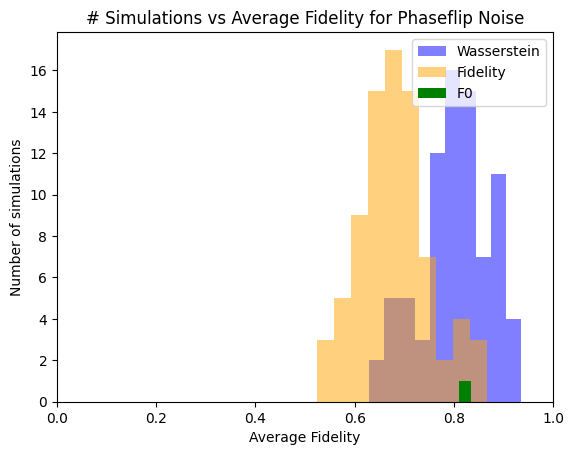

In [24]:
plotSimulation(wassIterationsPhaseflip, fidelityIterationsPhaseFlip, wassFidelityPhaseflip, fidelityFidelityPhaseFlip, "Phaseflip")

# Live Demo

In [33]:
# Number of iterations
num_its = 1

# Number of simulations
num_sim = 1

In [34]:
def F0_simulation(noiseModel, bitFlip):
    opt = qml.MomentumOptimizer(stepsize, momentum)

    # Create unitary set of 6 matrices
    I = qml.Identity.compute_matrix()
    X = qml.PauliX.compute_matrix()
    H = qml.Hadamard.compute_matrix()
    S = qml.S.compute_matrix()
    unitaries = [I, X, H, H @ X, S @ H, S @ H @ X]
    
    density_matrices = []
    iterations = []
    for unitary in unitaries:
        alpha = np.zeros((alpha_length,))
        beta = np.zeros((beta_length,))
        i = 0
        running_costs = []
        while i < num_its:
            (alpha, beta), _cost = opt.step_and_cost(noiseModel(unitary), alpha, beta)
            running_costs.append(_cost)
            i += 1

        density_matrices.append(find_density(unitary, alpha, beta, bitFlip))
        iterations.append(i)

    #Find ideal state for fidelity
    ideal_state = unitary_density()

    #Find state after error correction
    final_state = np.zeros((dim, dim), dtype=complex)
    for i in range(len(density_matrices)):
        final_state += density_matrices[i]
    
    final_state /= len(unitaries)

    fidelity = qml.math.fidelity(ideal_state, final_state)    
    return alpha, beta, iterations, fidelity


In [35]:
_, _, _, fidelity = F0_simulation(fidelity_cost_phaseflip_noise, False)
fidelity

0.8222222222222216

In [36]:
_, _, _, fidelity = F0_simulation(wasserstein_cost_phaseflip_noise, False)
fidelity


0.8222222222222216

## Wasserstein then Fidelity

In [ ]:
fidelityDiff = []
for i in range(num_sim):
    wassAlpha, wassBeta, _, wassFidelity = simulation(wasserstein_cost_phaseflip_noise, False)

    _, _, _, fidelityFidelity = simulation(fidelity_cost_phaseflip_noise, False)

    fidelityDiff.append(fidelityDiff - wassFidelity)



plt.hist(fidelityDiff, color='blue')

plt.xlabel("Fidelity")
plt.ylabel("Number of simulations")
plt.show()

## Fidelity then Wasserstein

In [ ]:
fidelityDiff = []
for i in range(num_sim):
    fidelityAlpha, fidelityBeta, _, fidelityFidelity = simulation(fidelity_cost_phaseflip_noise, False)

    _, _, _, fidelityFidelity = simulation(wasserstein_cost_phaseflip_noise, False)

    fidelityDiff.append(fidelityDiff - fidelityFidelity)


plt.hist(fidelityDiff, color='orange')

plt.xlabel("Fidelity")
plt.ylabel("Number of simulations")
plt.show()